# Chapter 2: Forces（力）

このノートブックは [Nature of Code](https://natureofcode.com/forces/) の第2章をJuliaで実装したものです。

## 概要

この章では、ニュートンの運動法則に基づいた力のシミュレーションを学びます。

### ニュートンの運動法則

1. **第1法則（慣性の法則）**: 物体は外力を受けない限り、静止または等速直線運動を続ける
2. **第2法則**: F = ma（力 = 質量 × 加速度）
3. **第3法則（作用・反作用の法則）**: すべての作用には等しい反作用がある

In [1]:
using Plots
using LinearAlgebra
using Random

## 2.1 ヘルパー関数

In [2]:
# ベクトル操作のヘルパー関数
setmag(v, mag) = norm(v) > 0 ? v * (mag / norm(v)) : v
limit(v, max_mag) = norm(v) > max_mag ? setmag(v, max_mag) : v
random2d() = [cos(rand() * 2π), sin(rand() * 2π)]

random2d (generic function with 1 method)

## 2.2 Moverクラス（力を受ける物体）

ニュートンの第2法則: **a = F / m**

力を物体に適用するには、力を質量で割って加速度に加えます。

In [3]:
mutable struct Mover
    position::Vector{Float64}
    velocity::Vector{Float64}
    acceleration::Vector{Float64}
    mass::Float64
end

function Mover(x::Float64, y::Float64, m::Float64)
    Mover([x, y], [0.0, 0.0], [0.0, 0.0], m)
end

function applyforce!(m::Mover, force::Vector{Float64})
    # F = ma → a = F/m
    f = force ./ m.mass
    m.acceleration .+= f
end

function update!(m::Mover)
    m.velocity .+= m.acceleration
    m.position .+= m.velocity
    m.acceleration .= 0.0  # 加速度をリセット
end

function check_edges!(m::Mover, width, height)
    r = m.mass * 4  # 半径は質量に比例
    if m.position[1] > width - r
        m.position[1] = width - r
        m.velocity[1] *= -1
    elseif m.position[1] < r
        m.position[1] = r
        m.velocity[1] *= -1
    end
    if m.position[2] > height - r
        m.position[2] = height - r
        m.velocity[2] *= -1
    elseif m.position[2] < r
        m.position[2] = r
        m.velocity[2] *= -1
    end
end

check_edges! (generic function with 1 method)

## 2.3 重力の適用

物体に重力を適用し、地面でバウンドさせます。

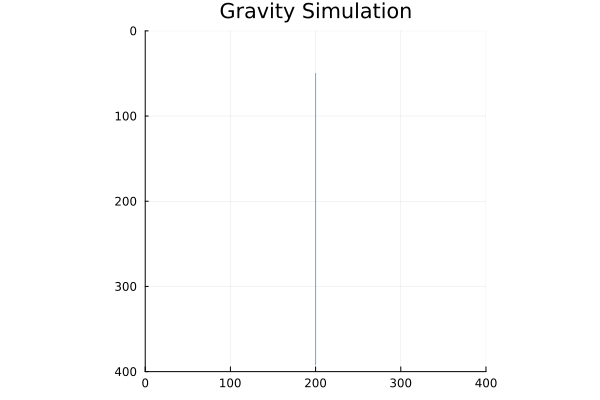

In [4]:
function simulate_gravity(steps::Int; width=400, height=400)
    mover = Mover(width/2, 50.0, 2.0)
    
    positions = [copy(mover.position)]
    
    for _ in 1:steps
        # 重力（質量に比例させる）
        gravity = [0.0, 0.2 * mover.mass]
        applyforce!(mover, gravity)
        
        update!(mover)
        check_edges!(mover, width, height)
        push!(positions, copy(mover.position))
    end
    
    return positions
end

positions = simulate_gravity(300)
xs = [p[1] for p in positions]
ys = [p[2] for p in positions]

plot(xs, ys, legend=false, linewidth=1, alpha=0.7,
     xlims=(0, 400), ylims=(0, 400), aspect_ratio=:equal,
     title="Gravity Simulation", yflip=true)

## 2.4 複数の物体と重力

質量の異なる複数の物体が同時に落下します。

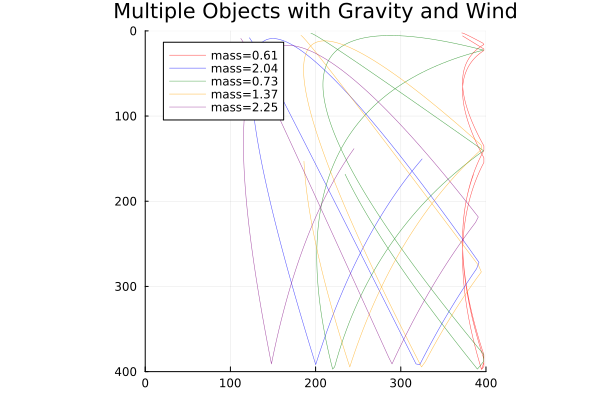

In [5]:
function simulate_multiple_gravity(n_movers::Int, steps::Int; width=400, height=400)
    movers = [Mover(rand()*width, 0.0, rand()*2 + 0.5) for _ in 1:n_movers]
    
    all_positions = [Vector{Vector{Float64}}() for _ in 1:n_movers]
    masses = [m.mass for m in movers]
    
    for _ in 1:steps
        for (i, mover) in enumerate(movers)
            # 重力
            gravity = [0.0, 0.1 * mover.mass]
            applyforce!(mover, gravity)
            
            # 風（一定の力）
            wind = [0.1, 0.0]
            applyforce!(mover, wind)
            
            update!(mover)
            check_edges!(mover, width, height)
            push!(all_positions[i], copy(mover.position))
        end
    end
    
    return all_positions, masses
end

all_positions, masses = simulate_multiple_gravity(5, 300)

p = plot(xlims=(0, 400), ylims=(0, 400), aspect_ratio=:equal, yflip=true)
colors = [:red, :blue, :green, :orange, :purple]

for (i, positions) in enumerate(all_positions)
    xs = [p[1] for p in positions]
    ys = [p[2] for p in positions]
    plot!(xs, ys, color=colors[i], linewidth=0.5, alpha=0.7, 
          label="mass=$(round(masses[i], digits=2))")
end

title!("Multiple Objects with Gravity and Wind")
p

## 2.5 摩擦力

摩擦力は速度の反対方向に作用し、物体を減速させます。

$$\vec{F}_{friction} = -\mu \cdot N \cdot \hat{v}$$

- μ: 摩擦係数
- N: 垂直抗力（簡略化のため1とする）
- v̂: 速度の単位ベクトル

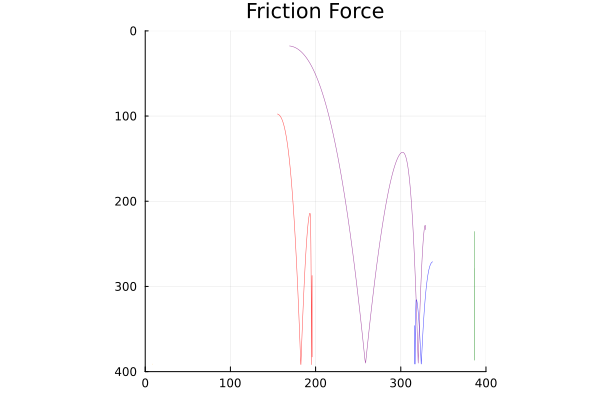

In [6]:
function simulate_friction(steps::Int; width=400, height=400)
    movers = [Mover(rand()*width, rand()*height, rand()*3 + 1) for _ in 1:5]
    for m in movers
        m.velocity = [rand()*4 - 2, 0.0]
    end
    
    all_positions = [Vector{Vector{Float64}}() for _ in 1:length(movers)]
    
    for _ in 1:steps
        for (i, mover) in enumerate(movers)
            # 重力
            gravity = [0.0, 0.1 * mover.mass]
            applyforce!(mover, gravity)
            
            # 摩擦力
            if norm(mover.velocity) > 0
                friction = copy(mover.velocity)
                friction = normalize(friction)
                friction .*= -1
                c = 0.05  # 摩擦係数
                friction .*= c
                applyforce!(mover, friction)
            end
            
            update!(mover)
            check_edges!(mover, width, height)
            push!(all_positions[i], copy(mover.position))
        end
    end
    
    return all_positions
end

all_positions = simulate_friction(300)

p = plot(xlims=(0, 400), ylims=(0, 400), aspect_ratio=:equal, yflip=true, legend=false)
colors = [:red, :blue, :green, :orange, :purple]

for (i, positions) in enumerate(all_positions)
    xs = [p[1] for p in positions]
    ys = [p[2] for p in positions]
    plot!(xs, ys, color=colors[i], linewidth=0.5, alpha=0.7)
end

title!("Friction Force")
p

## 2.6 流体抵抗（抗力）

物体が流体（水など）を通過するときの抵抗力。

$$\vec{F}_{drag} = -\frac{1}{2} \rho v^2 A C_d \hat{v}$$

簡略化すると: 抗力は速度の2乗に比例

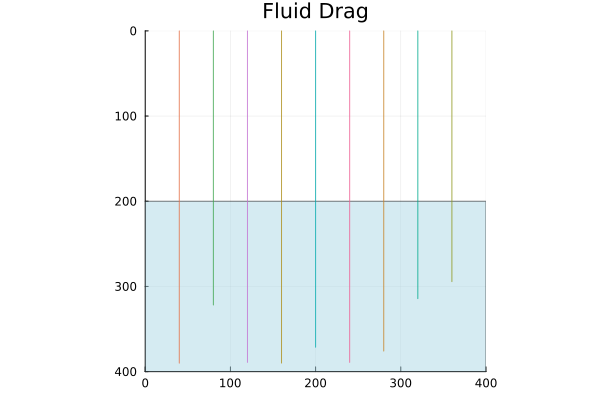

In [7]:
struct Liquid
    x::Float64
    y::Float64
    w::Float64
    h::Float64
    c::Float64  # 抗力係数
end

function contains(liq::Liquid, m::Mover)
    pos = m.position
    return liq.x < pos[1] < liq.x + liq.w && liq.y < pos[2] < liq.y + liq.h
end

function calculate_drag(liq::Liquid, m::Mover)
    speed = norm(m.velocity)
    drag_magnitude = liq.c * speed * speed
    
    drag = copy(m.velocity)
    drag .*= -1
    if norm(drag) > 0
        drag = normalize(drag)
    end
    drag .*= drag_magnitude
    
    return drag
end

function simulate_drag(steps::Int; width=400, height=400)
    movers = [Mover(40.0 + i * 40, 0.0, rand() * 2.5 + 0.5) for i in 0:8]
    liquid = Liquid(0.0, height/2, Float64(width), height/2, 0.1)
    
    all_positions = [Vector{Vector{Float64}}() for _ in 1:length(movers)]
    
    for _ in 1:steps
        for (i, mover) in enumerate(movers)
            # 流体内にいるか確認
            if contains(liquid, mover)
                drag = calculate_drag(liquid, mover)
                applyforce!(mover, drag)
            end
            
            # 重力
            gravity = [0.0, 0.1 * mover.mass]
            applyforce!(mover, gravity)
            
            update!(mover)
            
            # 底で反発
            r = mover.mass * 4
            if mover.position[2] > height - r
                mover.position[2] = height - r
                mover.velocity[2] *= -0.9
            end
            
            push!(all_positions[i], copy(mover.position))
        end
    end
    
    return all_positions, liquid
end

all_positions, liquid = simulate_drag(200)

p = plot(xlims=(0, 400), ylims=(0, 400), aspect_ratio=:equal, yflip=true, legend=false)

# 流体を描画
plot!(Shape([liquid.x, liquid.x+liquid.w, liquid.x+liquid.w, liquid.x],
            [liquid.y, liquid.y, liquid.y+liquid.h, liquid.y+liquid.h]),
      fillcolor=:lightblue, alpha=0.5)

for (i, positions) in enumerate(all_positions)
    xs = [p[1] for p in positions]
    ys = [p[2] for p in positions]
    plot!(xs, ys, linewidth=1, alpha=0.8)
end

title!("Fluid Drag")
p

## 2.7 万有引力

ニュートンの万有引力の法則：

$$F = G \frac{m_1 m_2}{r^2}$$

- G: 万有引力定数
- m₁, m₂: 2つの物体の質量
- r: 物体間の距離

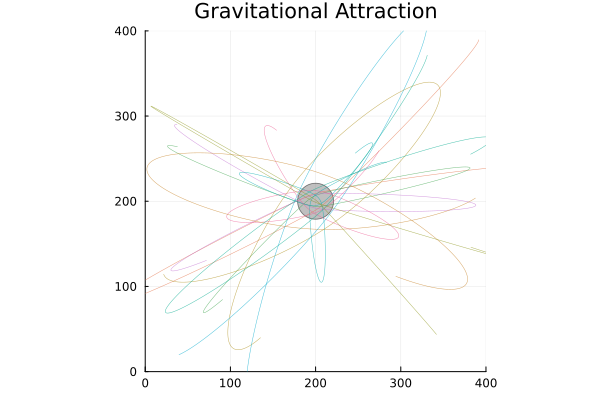

In [8]:
struct Attractor
    position::Vector{Float64}
    mass::Float64
    G::Float64  # 万有引力定数
end

function attract(a::Attractor, m::Mover)
    force = a.position - m.position
    distance = norm(force)
    # 距離を制限（極端な値を避ける）
    distance = clamp(distance, 5.0, 25.0)
    
    if norm(force) > 0
        force = normalize(force)
    end
    strength = (a.G * a.mass * m.mass) / (distance * distance)
    force .*= strength
    
    return force
end

function simulate_attraction(steps::Int; width=400, height=400)
    movers = [Mover(rand()*width, rand()*height, rand()*1.5 + 0.5) for _ in 1:10]
    for m in movers
        m.velocity = [rand()*2 - 1, rand()*2 - 1]
    end
    
    attractor = Attractor([width/2, height/2], 20.0, 1.0)
    
    all_positions = [Vector{Vector{Float64}}() for _ in 1:length(movers)]
    
    for _ in 1:steps
        for (i, mover) in enumerate(movers)
            force = attract(attractor, mover)
            applyforce!(mover, force)
            
            update!(mover)
            push!(all_positions[i], copy(mover.position))
        end
    end
    
    return all_positions, attractor
end

all_positions, attractor = simulate_attraction(500)

p = plot(xlims=(0, 400), ylims=(0, 400), aspect_ratio=:equal, legend=false)

# アトラクターを描画
scatter!([attractor.position[1]], [attractor.position[2]], 
         markersize=20, color=:gray, alpha=0.5)

for positions in all_positions
    xs = [p[1] for p in positions]
    ys = [p[2] for p in positions]
    plot!(xs, ys, linewidth=0.5, alpha=0.7)
end

title!("Gravitational Attraction")
p

## 2.8 N体問題

複数の物体が互いに引力を及ぼし合うシミュレーションです。

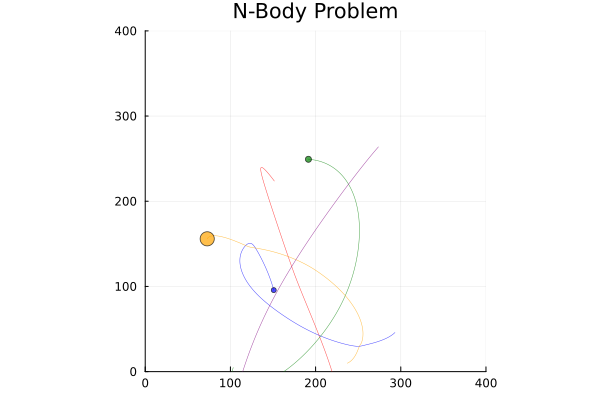

In [9]:
mutable struct Body
    position::Vector{Float64}
    velocity::Vector{Float64}
    acceleration::Vector{Float64}
    mass::Float64
    G::Float64
end

function Body(x::Float64, y::Float64, m::Float64)
    Body([x, y], [rand()*2-1, rand()*2-1], [0.0, 0.0], m, 0.4)
end

function attract_body(a::Body, b::Body)
    force = a.position - b.position
    distance = clamp(norm(force), 5.0, 25.0)
    
    if norm(force) > 0
        force = normalize(force)
    end
    strength = (a.G * a.mass * b.mass) / (distance * distance)
    force .*= strength
    
    return force
end

function applyforce_body!(b::Body, force::Vector{Float64})
    f = force ./ b.mass
    b.acceleration .+= f
end

function update_body!(b::Body)
    b.velocity .+= b.acceleration
    b.position .+= b.velocity
    b.acceleration .= 0.0
end

function simulate_nbody(n_bodies::Int, steps::Int; width=400, height=400)
    bodies = [Body(rand()*width, rand()*height, rand()*15 + 5) for _ in 1:n_bodies]
    
    all_positions = [Vector{Vector{Float64}}() for _ in 1:n_bodies]
    masses = [b.mass for b in bodies]
    
    for _ in 1:steps
        # すべての物体ペアで引力を計算
        for i in 1:n_bodies
            for j in 1:n_bodies
                if i != j
                    force = attract_body(bodies[j], bodies[i])
                    applyforce_body!(bodies[i], force)
                end
            end
        end
        
        for (i, body) in enumerate(bodies)
            update_body!(body)
            push!(all_positions[i], copy(body.position))
        end
    end
    
    return all_positions, masses
end

all_positions, masses = simulate_nbody(5, 300)

p = plot(xlims=(0, 400), ylims=(0, 400), aspect_ratio=:equal, legend=false)
colors = [:red, :blue, :green, :orange, :purple]

for (i, positions) in enumerate(all_positions)
    xs = [p[1] for p in positions]
    ys = [p[2] for p in positions]
    plot!(xs, ys, color=colors[i], linewidth=0.5, alpha=0.7)
    # 最終位置に円を描画
    scatter!([xs[end]], [ys[end]], color=colors[i], markersize=masses[i]/2, alpha=0.7)
end

title!("N-Body Problem")
p

## まとめ

### ニュートンの運動法則

| 法則 | 内容 |
|------|------|
| 第1法則 | 物体は外力を受けない限り、静止または等速直線運動を続ける |
| 第2法則 | F = ma（加速度は力に比例し、質量に反比例） |
| 第3法則 | 作用・反作用は等しい大きさで逆向き |

### 力の公式

| 力 | 公式 | 特徴 |
|----|------|------|
| 重力 | F = mg | 質量に比例 |
| 摩擦力 | F = -μN × v̂ | 速度の反対方向 |
| 抗力 | F = -½ρv²ACd × v̂ | 速度の2乗に比例 |
| 万有引力 | F = Gm₁m₂/r² | 距離の2乗に反比例 |

### 実装のポイント

1. **毎フレーム加速度をリセットする**: 力は累積的に適用され、次のフレームでは0からやり直す
2. **力を適用する際は質量で割る**: F = ma → a = F/m
3. **距離は適切な範囲に制限する**: 極端な値を避けてシミュレーションの安定性を保つ